<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W1D5/tutorials/W1D5-DimensionalityReduction/W1D5-Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week 1, Day 5, Tutorial 1
# Dimensionality Reduction: Geometric view of data


---

Tutorial objectives
In this notebook we'll explore how multivariate data can be represented in different orthonormal bases. This will help us build intuition that will be helpful in understanding PCA in the following tutorial. 

Steps:
 1. Generate correlated multivariate data.
 2. Define an arbitrary orthonormal basis. 
 3. Project data onto new basis.

---

Video available at https://youtube.com/watch?v=emLW0F-VUag


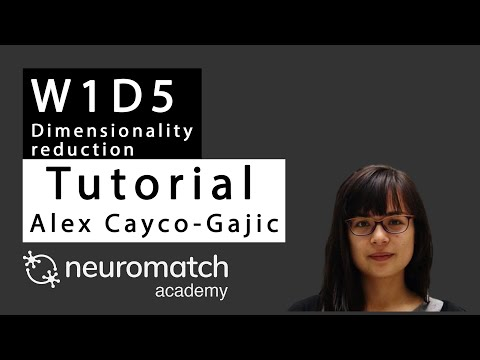

In [1]:
#@title Video: Geometric view of data
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="emLW0F-VUag", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video



# Setup
Run these cells to get the tutorial started.

In [2]:
#library imports
import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display        


In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 8)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [4]:
#@title Helper functions

def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random variable.

  Args:
    cov_matrix (numpy array of floats): desired covariance matrix
  
  Returns: 
    (numpy array of floats) : samples from the bivariate Gaussian, with
                              each column corresponding to a different random variable
  """
  mean = np.array([0,0])
  X = np.random.multivariate_normal(mean,cov_matrix,size = 1000)
  indices_for_sorting = np.argsort(X[:,0])
  X = X[indices_for_sorting,:]
  return X


def plot_data(X):
  """
  Plots bivariate data. Includes a plot of each random variable, and a scatter
  plot of their joint activity. The title indicates the sample correlation
  calculated from the data.

  Args:
    X (numpy array of floats):   Data matrix
                                  each column corresponds to a different random variable 
            
  Returns:
    Nothing.
  """
  fig = plt.figure(figsize=[8,4])
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0,0])
  ax1.plot(X[:,0],color='k')
  plt.ylabel('Neuron 1')
  plt.title('Sample var 1: {:.1f}'.format(np.var(X[:,0])))
  ax1.set_xticklabels([])
  ax2 = fig.add_subplot(gs[1,0])
  ax2.plot(X[:,1],color='k')
  plt.xlabel('Sample Number')
  plt.ylabel('Neuron 2')
  plt.title('Sample var 2: {:.1f}'.format(np.var(X[:,1])))
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(X[:,0],X[:,1],'.',markerfacecolor=[.5,.5,.5], markeredgewidth=0)
  ax3.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(X[:,0],X[:,1])[0,1]))

def plot_basis_vectors(X,W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats):   Data matrix 
                                  each column corresponds to a different random variable 
    W (numpy array of floats):   Square matrix representing new orthonormal basis
                                  each column represents a basis vector
            
  Returns:
    Nothing.
  """
  plt.figure(figsize=[4,4])
  plt.plot(X[:,0],X[:,1],'.',color=[.5,.5,.5],label='Data')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  plt.plot([0,W[0,0]],[0,W[1,0]],color='r',linewidth=3,label = 'Basis vector 1')
  plt.plot([0,W[0,1]],[0,W[1,1]],color='b',linewidth=3,label = 'Basis vector 2')
  plt.legend()

def plot_data_new_basis(Y):
  """
  Plots bivariate data after transformation to new bases. Similar to plot_data but
  with colors corresponding to projections onto basis 1 (red) and basis 2 (blue).
  The title indicates the sample correlation calculated from the data.

  Note that samples are re-sorted in ascending order for the first random variable.
  
  Args:
    Y (numpy array of floats):   Data matrix in new basis
                                  each column corresponds to a different random variable 
            
  Returns:
    Nothing.
  """
  fig = plt.figure(figsize=[8,4])
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0,0])
  ax1.plot(Y[:,0],'r')
  plt.xlabel
  plt.ylabel('Projection \n basis vector 1')
  plt.title('Sample var 1: {:.1f}'.format(np.var(Y[:,0])))
  ax1.set_xticklabels([])
  ax2 = fig.add_subplot(gs[1,0])
  ax2.plot(Y[:,1],'b')
  plt.xlabel('Sample number')
  plt.ylabel('Projection \n basis vector 2')
  plt.title('Sample var 2: {:.1f}'.format(np.var(Y[:,1])))
  ax3 = fig.add_subplot(gs[:, 1])
  ax3.plot(Y[:,0],Y[:,1],'.',color=[.5,.5,.5])
  ax3.axis('equal')
  plt.xlabel('Projection basis vector 1')
  plt.ylabel('Projection basis vector 2')
  plt.title('Sample corr: {:.1f}'.format(np.corrcoef(Y[:,0],Y[:,1])[0,1]))


# Generate correlated multivariate data

Video available at https://youtube.com/watch?v=YOan2BQVzTQ


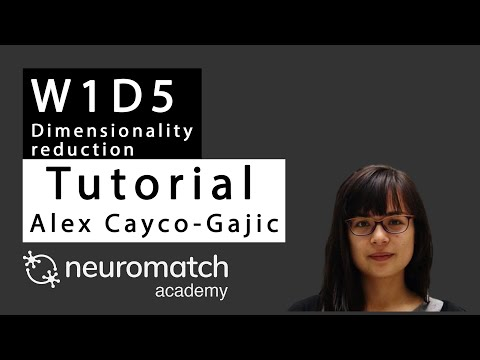

In [5]:
#@title Video: Multivariate data
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="YOan2BQVzTQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


To study multivariate data, first we generate it. In this exercise we generate data from a *bivariate normal distribution*. This is an extension of the one-dimensional normal distribution to two dimensions, in which each $x_i$ is marginally normal with mean $\mu_i$ and variance $\sigma_i^2$:

\begin{align}
x_i \sim \mathcal{N}(\mu_i,\sigma_i^2)
\end{align}

Additionally, the joint distribution for $x_1$ and $x_2$ has a specified correlation coefficient $\rho$. Recall that the correlation coefficient is a normalized version of the covariance, and ranges between -1 and +1.  

\begin{align}
\rho = \frac{\text{cov}(x_1,x_2)}{\sqrt{\sigma_1^2 \sigma_2^2}}
\end{align}

For simplicity, we will assume that the mean of each variable has already been subtracted, so that $\mu_i=0$. The remaining parameters can be summarized in the covariance matrix:
\begin{equation*}
{\bf \Sigma} = 
\begin{pmatrix}
 \text{var}(x_1) & \text{cov}(x_1,x_2) \\
 \text{cov}(x_1,x_2) &\text{var}(x_2)
\end{pmatrix}
\end{equation*}
Note that this is a symmetric matrix with the variances $\text{var}(x_i) = \sigma_i^2$ on the diagonal, and the covariance on the off-diagonal.




### Exercise
We have provided code to draw random samples from a zero-mean bivariate normal distribution. These samples could be used to simulate changes in firing rates for two neurons. Fill in the function below to calculate the covariance matrix given the desired variances and correlation coefficient. The covariance can be found by rearranging the equation above:

\begin{align}
\text{cov}(x_1,x_2) = \rho \sqrt{\sigma_1^2 \sigma_2^2}
\end{align}

Use these functions to generate and plot data while varying the parameters. You should get a feel for how changing the correlation coefficient affects the geometry of the simulated data.

**Suggestions**
* Fill in the function `calculate_cov_matrix` to calculate the covariance.
* Generate and plot the data for $\sigma_1^2 =1$, $\sigma_1^2 =1$, and $\rho = .8$. Try plotting the data for different values of the correlation coefficent: $\rho = -1, -.5, 0, .5, 1$.

In [6]:
help(plot_data)
help(get_data)

Help on function plot_data in module __main__:

plot_data(X)
    Plots bivariate data. Includes a plot of each random variable, and a scatter
    plot of their joint activity. The title indicates the sample correlation
    calculated from the data.
    
    Args:
      X (numpy array of floats):   Data matrix
                                    each column corresponds to a different random variable 
              
    Returns:
      Nothing.

Help on function get_data in module __main__:

get_data(cov_matrix)
    Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian
    
    Note that samples are sorted in ascending order for the first random variable.
    
    Args:
      cov_matrix (numpy array of floats): desired covariance matrix
    
    Returns: 
      (numpy array of floats) : samples from the bivariate Gaussian, with
                                each column corresponding to a different random variable



In [7]:

def calculate_cov_matrix(var_1,var_2,corr_coef):
  """
  Calculates the covariance matrix based on the variances and correlation coefficient.
  
  Args:
    var_1 (scalar):    variance of the first random variable
    var_2 (scalar):    variance of the second random variable
    corr_coef (scalar):      correlation coefficient
  
  Returns: 
    (numpy array of floats) : covariance matrix
  """
  ###################################################################
  ## Insert your code here to:
  ##                calculate the covariance from the variances and correlation
  # cov = ...
  cov_matrix = np.array([[var_1,cov],[cov,var_2]])

  #uncomment once you've filled in the function
  raise NotImplementedError("Student excercise: calculate the covariance matrix!")
  ################################################################### 
  return cov


###################################################################
## Insert your code here to:
##                generate and plot bivariate Gaussian data with variances of 1
##                      and a correlation coefficients of: 0.8
##                repeat while varying the correlation coefficient from -1 to 1       
################################################################### 
variance_1 = 1
variance_2 = 1
corr_coef = 0.8

#uncomment to test your code and plot
#cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
#X = get_data(cov_matrix)
#plot_data(X)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


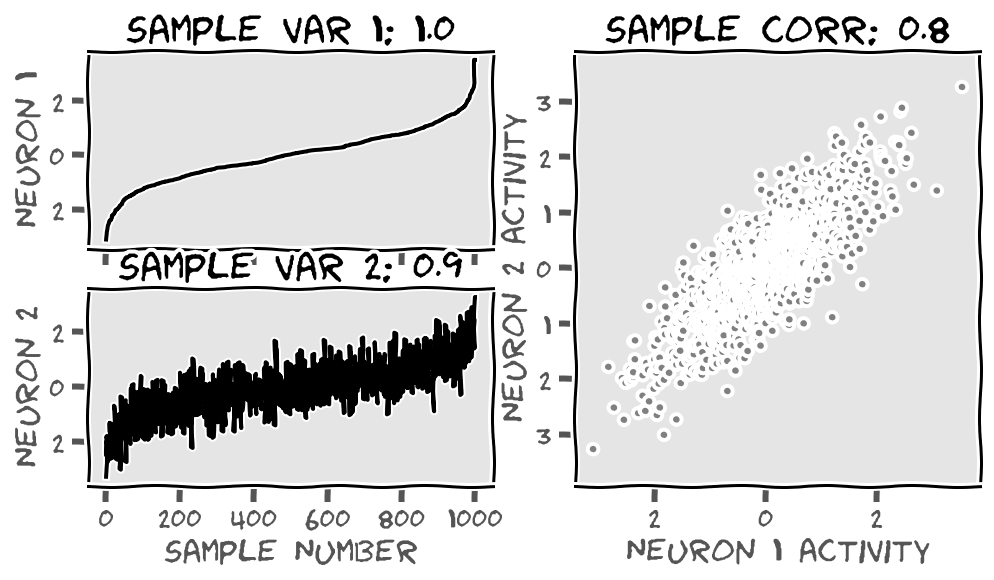

In [8]:
# to_remove solution

def calculate_cov_matrix(var_1,var_2,corr_coef):
  """
  Calculates the covariance matrix based on the variances and correlation coefficient.
  
  Args:
    var_1 (scalar):    variance of the first random variable
    var_2 (scalar):    variance of the second random variable
    corr_coef (scalar):      correlation coefficient
  
  Returns: 
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1,cov],[cov,var_2]])
  return cov_matrix

cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
X = get_data(cov_matrix)

with plt.xkcd():
  plot_data(X)


# Define a new orthonormal basis


Video available at https://youtube.com/watch?v=dK526Nbn2Xo


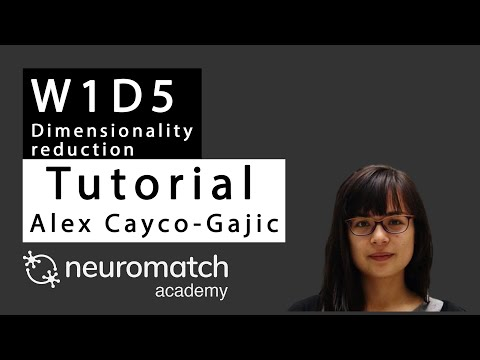

In [9]:
#@title Video: Orthonormal bases
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="dK526Nbn2Xo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Next, we will define a new orthonormal basis of vectors ${\bf u} = [u_1,u_2]$ and ${\bf w} = [w_1,w_2]$. As we learned in the video, two vectors are orthonormal if: 

1.   They are orthogonal (i.e., their dot product is zero):
\begin{equation}
{\bf u\cdot w} = u_1 w_1 + u_2 w_2 = 0
\end{equation}
2.   They have unit length:
\begin{equation}
||{\bf u} || = ||{\bf w} || = 1
\end{equation}

In two dimensions, it is easy to make an arbitrary orthonormal basis. All we need is a random vector ${\bf u}$, which we have normalized. If we now define the second basis vector to be ${\bf w} = [-u_2,u_1]$, we can check that both conditions are satisfied: 
\begin{equation}
{\bf u\cdot w} = - u_1 u_2 + u_2 u_1 = 0
\end{equation}
and 
\begin{equation}
{|| {\bf w} ||} = \sqrt{(-u_2)^2 + u_1^2} = \sqrt{u_1^2 + u_2^2} = 1,
\end{equation}
where we used the fact that ${\bf u}$ is normalized. So, with an arbitrary input vector, we can define an orthonormal basis, which we will write in matrix by stacking the basis vectors horizontally:

\begin{equation}
{{\bf W} } =
\begin{pmatrix}
 u_1 & w_1 \\
 u_2 & w_2
\end{pmatrix}.
\end{equation}

### Exercise

In this exercise you will fill in the function below to define an orthonormal basis, given a single arbitrary 2-dimensional vector as an input.

**Suggestions**
* Modify the function `define_orthonormal_basis` to first normalize the first basis vector $\bf u$.
* Then complete the function by finding a basis vector $\bf w$ that is orthogonal to $\bf u$.
* Test the function using initial basis vector ${\bf u} = [3,1]$. Plot the resulting basis vectors on top of the data scatter plot using the function `plot_basis_vectors`. (For the data, use  $\sigma_1^2 =1$, $\sigma_1^2 =1$, and $\rho = .8$). 

In [10]:
help(plot_basis_vectors)

Help on function plot_basis_vectors in module __main__:

plot_basis_vectors(X, W)
    Plots bivariate data as well as new basis vectors.
    
    Args:
      X (numpy array of floats):   Data matrix 
                                    each column corresponds to a different random variable 
      W (numpy array of floats):   Square matrix representing new orthonormal basis
                                    each column represents a basis vector
              
    Returns:
      Nothing.



In [11]:
def define_orthonormal_basis(u): 
  """
  Calculates an orthonormal basis given an arbitrary vector u.
  
  Args:
    u (numpy array of floats):    arbitrary 2-dimensional vector used for new basis
  
  Returns: 
    (numpy array of floats) : new orthonormal basis
                                columns correspond to basis vectors
  """
  ###################################################################
  ## Insert your code here to:
  ##                normalize vector u
  ##                calculate vector w that is orthogonal to w    

  #u = ....
  #w = ...
  #W = np.column_stack((u,w))

  #comment this once you've filled the function
  raise NotImplementedError("Student excercise: implement the orthonormal basis function")
  ###################################################################
  return W

variance_1 = 1
variance_2 = 1
corr_coef = 0.8

cov_matrix = calculate_cov_matrix(variance_1,variance_2,corr_coef)
X = get_data(cov_matrix)
u = np.array([3,1])

#uncomment and run below to plot the basis vectors
##define_orthonormal_basis(u)
#plot_basis_vectors(X,W)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


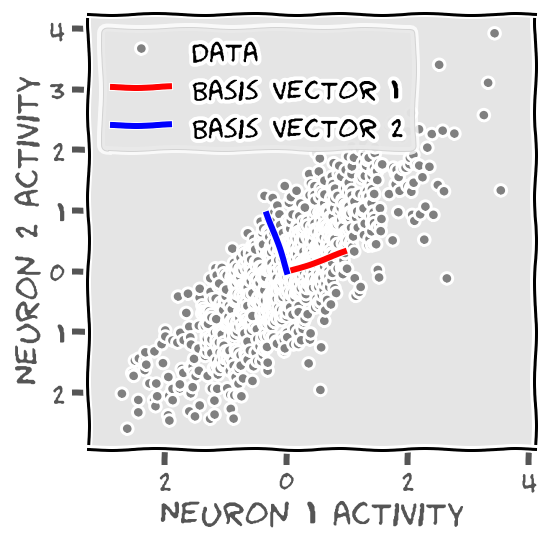

In [12]:
# to_remove solution

def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.
  
  Args:
    u (numpy array of floats):    arbitrary 2-dimensional vector used for new basis
  
  Returns: 
    (numpy array of floats) : new orthonormal basis
                                columns correspond to basis vectors
  """
  u = u / np.sqrt(u[0]**2 + u[1]**2)
  w = np.array([-u[1],u[0]])
  W = np.column_stack((u,w))
  return W


W = define_orthonormal_basis(u)

with plt.xkcd():
  plot_basis_vectors(X,W)

# Project data onto new basis

Video available at https://youtube.com/watch?v=5MWSUtpbSt0


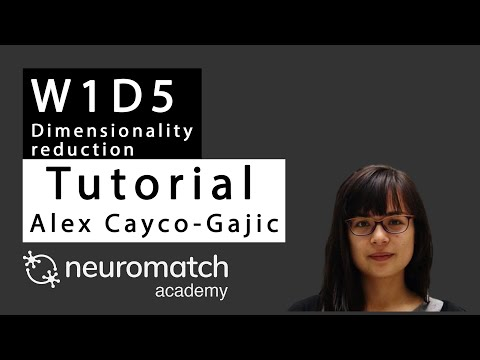

In [13]:
#@title Video: Change of basis
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="5MWSUtpbSt0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


   
Finally, we will express our data in the new basis that we have just found. Since $\bf W$ is orthonormal, we can project the data into our new basis using simple matrix multiplication :

\begin{equation}
{\bf Y = X W}.
\end{equation}

We will explore the geometry of the transformed data $\bf Y$ as we vary the choice of basis.

#### Exercise
In this exercise you will fill in the function below to define an orthonormal basis, given a single arbitrary vector as an input.

**Suggestions**
* Complete the function `change_of_basis` to project the data onto the new basis.
* Plot the projected data using the function `plot_data_new_basis`. 
* What happens to the correlation coefficient in the new basis? Does it increase or decrease? 
* What happens to variance? 



In [14]:
def change_of_basis(X,W):
  """
  Projects data onto new basis W.
  
  Args:
    X (numpy array of floats) : Data matrix
                                each column corresponding to a different random variable
    W (numpy array of floats):  new orthonormal basis
                                columns correspond to basis vectors
  
  Returns: 
    (numpy array of floats) : Data matrix expressed in new basis
  """
  ###################################################################
  ## Insert your code here to:
  ##                project data onto new basis described by W 

  #Y = ...
  #comment this once you've filled the function
  raise NotImplementedError("Student excercise: implement change of basis")
  ################################################################### 
  return Y

## Unomment below to transform the data by projecting it into the new basis
## Plot the projected data
# Y = change_of_basis(X,W)
# plot_data_new_basis(Y)
# disp(...)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


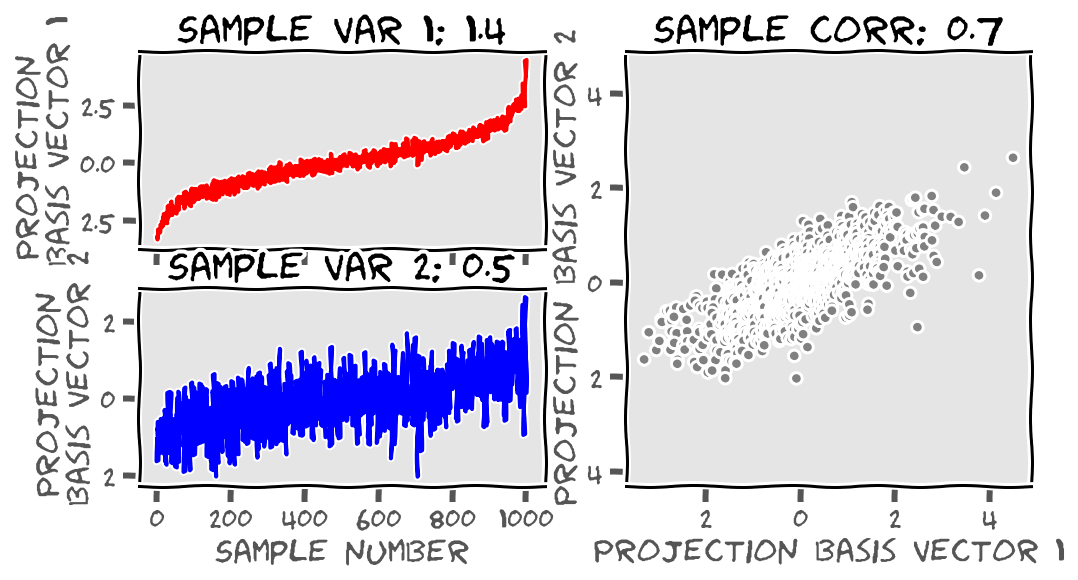

In [15]:
# to_remove solution
def change_of_basis(X,W):
  """
  Projects data onto a new basis.
  
  Args:
    X (numpy array of floats) : Data matrix
                                each column corresponding to a different random variable
    W (numpy array of floats):  new orthonormal basis
                                columns correspond to basis vectors
  
  Returns: 
    (numpy array of floats) : Data matrix expressed in new basis
  """
  Y = np.matmul(X,W)
  return Y

Y = change_of_basis(X,W)

with plt.xkcd():
  plot_data_new_basis(Y)


#### Exercise
To see what happens to the correlation as we change the basis vectors, run the cell below. The parameter $\theta$ controls the angle of $\bf u$ in degrees. Use the slider to rotate the basis vectors. 

**Questions**
* What happens to the projected data as you rotate the basis? 
* How does the correlation coefficient change? How does the variance of the projection onto each basis vector change?
* Are you able to find a basis in which the projected data is uncorrelated? 

In [16]:
###### MAKE SURE TO RUN THIS CELL VIA THE PLAY BUTTON TO ENABLE SLIDERS ########

import ipywidgets as widgets

def refresh(theta = 0):
  u = [1,np.tan(theta * np.pi/180.)]
  W = define_orthonormal_basis(u)
  Y = change_of_basis(X,W)
  plot_basis_vectors(X,W)
  plot_data_new_basis(Y)

_ = widgets.interact(refresh, 
  theta = (0, 90, 5))

interactive(children=(IntSlider(value=0, description='theta', max=90, step=5), Output()), _dom_classes=('widge…